In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
sns.set_style("ticks")
sns.set_palette('muted')

In [124]:
data = pd.read_csv('CAX_MortgageModeling_Train.csv')
dfx = pd.DataFrame(data)

In [125]:
dfx.shape

(45642, 22)

In [126]:
#Checking Imbalances
dfx['RESULT'].value_counts(normalize=True)

FUNDED        0.789251
NOT FUNDED    0.210749
Name: RESULT, dtype: float64

In [127]:
#Checking for Zeros
dfx.isin([0]).any()

Unique_ID            False
MORTGAGE NUMBER      False
PROPERTY VALUE       False
MORTGAGE PAYMENT     False
GDS                   True
LTV                  False
TDS                   True
AMORTIZATION         False
MORTGAGE AMOUNT      False
RATE                 False
MORTGAGE PURPOSE     False
PAYMENT FREQUENCY    False
PROPERTY TYPE        False
TERM                 False
FSA                  False
AGE RANGE            False
GENDER               False
INCOME               False
INCOME TYPE          False
NAICS CODE           False
CREDIT SCORE          True
RESULT               False
dtype: bool

In [128]:
#Zero Counts
dfx[dfx[['GDS', 'TDS']] == 0].count()

Unique_ID              0
MORTGAGE NUMBER        0
PROPERTY VALUE         0
MORTGAGE PAYMENT       0
GDS                  319
LTV                    0
TDS                   74
AMORTIZATION           0
MORTGAGE AMOUNT        0
RATE                   0
MORTGAGE PURPOSE       0
PAYMENT FREQUENCY      0
PROPERTY TYPE          0
TERM                   0
FSA                    0
AGE RANGE              0
GENDER                 0
INCOME                 0
INCOME TYPE            0
NAICS CODE             0
CREDIT SCORE           0
RESULT                 0
dtype: int64

In [129]:
from sklearn.preprocessing import LabelEncoder

In [130]:
#Cleaning Function
def clean_data(df):
    
    # Set Index
    df.set_index('Unique_ID', inplace=True)
    
    # Drop Mortgage Number
    df.drop(['MORTGAGE NUMBER'], axis=1, inplace=True)
    
    # Update Property Value per Competition
    df['PROPERTY VALUE'] = df['MORTGAGE AMOUNT'] / (df['LTV'] / 100)
    
    # Set Negative GDS Values to Zero, per Competition
    df['GDS'] = np.where(df['GDS'] < 0, 0, df['GDS'])
    
    # Split FSA & Encode Urban or Rural
    df_temp = df['FSA'].str.split('', n=3, expand=True)
    df_temp[2] = df_temp[2].astype(int)
    df_temp['URBAN'] = np.where(df_temp[2] > 0, 1, 0)
    df_temp.drop([0, 2, 3], axis=1, inplace=True)
    
    # Name Territory Colum, drop old FSA column
    df_temp.rename(columns={1: 'TERRITORY'}, inplace=True)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['FSA'], axis=1, inplace=True)
    
    #Encode Results
    if 'RESULT' in df:
        
        le_result = LabelEncoder()
        df['RESULT'] = le_result.fit_transform(df['RESULT'])
        df['RESULT'] = df['RESULT'].replace({0: 1, 1:0})
    
    return df

df = clean_data(dfx)

In [131]:
# Drop significant Mortgage Amount & Property Value outliers

from scipy.stats import zscore

z_thresh = 3

def remove_outliers(df):
    
    df['mortgage_amt_z'] = zscore(df['MORTGAGE AMOUNT'])
    df['property_val_z'] = zscore(df['PROPERTY VALUE'])
    
    df = df[(df['property_val_z'] <= z_thresh) & (df['mortgage_amt_z'] <= z_thresh)]
    df = df.drop(['mortgage_amt_z', 'property_val_z'], axis=1)
    
    df = df[(df['RATE'] < 8) & (df['RATE'] > 3)]
    
    df = df[(df['LTV'] < 200)]
    
    return df

df = remove_outliers(df)
df['RESULT'].value_counts()

1    35245
0     9273
Name: RESULT, dtype: int64

In [132]:
# Some Credit Scores are Zero
df[df['CREDIT SCORE'] == 0].groupby('RESULT')['CREDIT SCORE'].count()

RESULT
0    297
1    854
Name: CREDIT SCORE, dtype: int64

In [133]:
# Check degree of Imbalance after Cleaning
df['RESULT'].value_counts(normalize=True)

1    0.791702
0    0.208298
Name: RESULT, dtype: float64

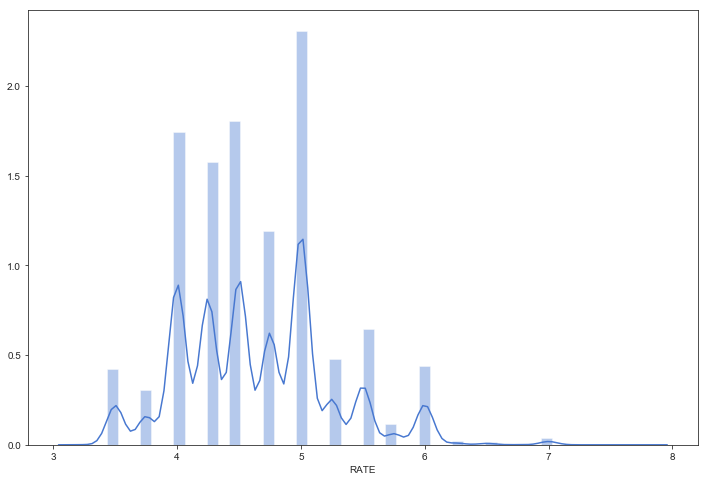

In [134]:
# Histogram of Rate
plt.figure(figsize=(12,8))
sns.distplot(df['RATE']);

## EDA

In [135]:
list_cols = list(df.columns.values)
list_cols

['PROPERTY VALUE',
 'MORTGAGE PAYMENT',
 'GDS',
 'LTV',
 'TDS',
 'AMORTIZATION',
 'MORTGAGE AMOUNT',
 'RATE',
 'MORTGAGE PURPOSE',
 'PAYMENT FREQUENCY',
 'PROPERTY TYPE',
 'TERM',
 'AGE RANGE',
 'GENDER',
 'INCOME',
 'INCOME TYPE',
 'NAICS CODE',
 'CREDIT SCORE',
 'RESULT',
 'TERRITORY',
 'URBAN']

In [136]:
# Re-arrange Columns
df = df[['PROPERTY VALUE',
 'MORTGAGE PAYMENT',
 'GDS',
 'LTV',
 'TDS',
 'AMORTIZATION',
 'MORTGAGE AMOUNT',
 'RATE',
 'MORTGAGE PURPOSE',
 'PAYMENT FREQUENCY',
 'PROPERTY TYPE',
 'TERM',
 'AGE RANGE',
 'GENDER',
 'INCOME',
 'INCOME TYPE',
 'NAICS CODE',
 'CREDIT SCORE',
 'TERRITORY',
 'URBAN',
 'RESULT']]

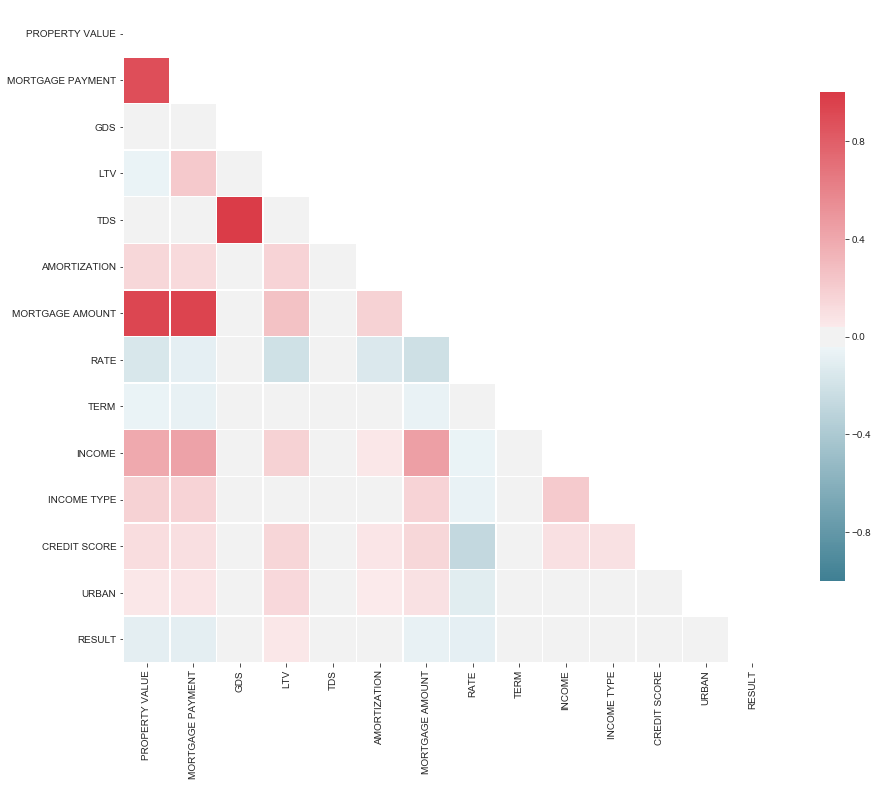

In [137]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [138]:
df.describe()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,URBAN,RESULT
count,4.451800e+04,44518.000000,4.451800e+04,44518.000000,4.451800e+04,44518.000000,4.451800e+04,44518.000000,44518.000000,4.451800e+04,44518.000000,44518.000000,44518.000000,44518.000000
mean,5.655856e+05,2242.164068,2.180961e+02,70.783750,4.215687e+02,355.303023,3.984070e+05,4.634474,15.319826,1.187545e+05,5.275170,662.103958,0.952828,0.791702
std,3.039868e+05,1193.800862,3.304709e+04,11.443805,6.506473e+04,18.039613,2.169652e+05,0.601591,7.438243,9.660801e+04,3.275694,132.883583,0.212009,0.406095
min,2.612277e+04,141.000000,0.000000e+00,6.667000,-1.070000e+01,60.000000,1.500000e+04,3.250000,6.000000,1.000000e+03,-1.000000,0.000000,0.000000,0.000000
25%,3.500000e+05,1396.000000,1.971000e+01,65.000000,3.277000e+01,360.000000,2.440000e+05,4.250000,12.000000,6.800000e+04,2.000000,622.000000,1.000000,1.000000
50%,4.969950e+05,2008.000000,2.911000e+01,75.000000,3.821000e+01,360.000000,3.520000e+05,4.500000,12.000000,9.600000e+04,6.000000,676.000000,1.000000,1.000000
75%,6.990144e+05,2801.000000,3.579000e+01,80.000000,4.208000e+01,360.000000,5.000000e+05,5.000000,12.000000,1.400000e+05,8.000000,735.000000,1.000000,1.000000
max,1.990000e+06,11464.000000,6.872300e+06,95.000000,1.346256e+07,480.000000,1.331250e+06,7.750000,60.000000,2.400000e+06,20.000000,899.000000,1.000000,1.000000


In [139]:
df.corr()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,URBAN,RESULT
PROPERTY VALUE,1.000000,0.886034,0.019137,-0.055643,0.018655,0.144450,0.931642,-0.158326,-0.057527,0.394165,0.172310,0.109624,0.056957,-0.097866
MORTGAGE PAYMENT,0.886034,1.000000,0.012074,0.223111,0.011754,0.131873,0.941708,-0.091635,-0.074393,0.430711,0.166316,0.106163,0.075624,-0.097021
GDS,0.019137,0.012074,1.000000,-0.011551,0.990829,0.001514,0.008826,0.004035,-0.002576,-0.006237,0.001881,0.001018,0.001279,0.002945
LTV,-0.055643,0.223111,-0.011551,1.000000,-0.011302,0.164606,0.263706,-0.210852,-0.025146,0.176039,-0.004221,0.154131,0.134020,0.057000
TDS,0.018655,0.011754,0.990829,-0.011302,1.000000,0.001546,0.008499,0.005000,-0.002637,-0.005635,0.002055,0.001593,0.001307,0.003014
AMORTIZATION,0.144450,0.131873,0.001514,0.164606,0.001546,1.000000,0.176618,-0.143146,-0.032769,0.059731,0.026389,0.069287,0.044969,0.012710
MORTGAGE AMOUNT,0.931642,0.941708,0.008826,0.263706,0.008499,0.176618,1.000000,-0.211147,-0.065268,0.446030,0.169057,0.144135,0.088984,-0.072343
RATE,-0.158326,-0.091635,0.004035,-0.210852,0.005000,-0.143146,-0.211147,1.000000,0.009861,-0.060881,-0.067560,-0.281122,-0.116745,-0.092801
TERM,-0.057527,-0.074393,-0.002576,-0.025146,-0.002637,-0.032769,-0.065268,0.009861,1.000000,-0.038833,0.016473,-0.007477,-0.020603,0.020783
INCOME,0.394165,0.430711,-0.006237,0.176039,-0.005635,0.059731,0.446030,-0.060881,-0.038833,1.000000,0.215357,0.094720,0.025952,-0.010768


In [140]:
#sns.pairplot(df);

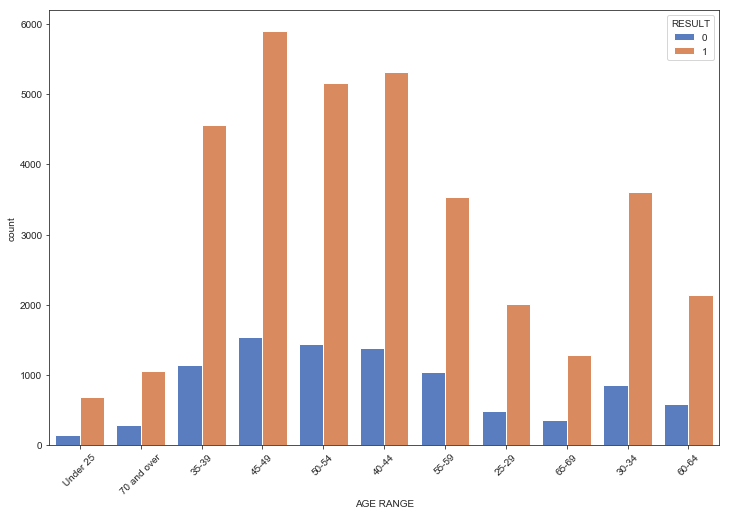

In [141]:
plt.figure(figsize=(12,8))
sns.countplot(df['AGE RANGE'], hue=df['RESULT'])
plt.xticks(rotation=45);

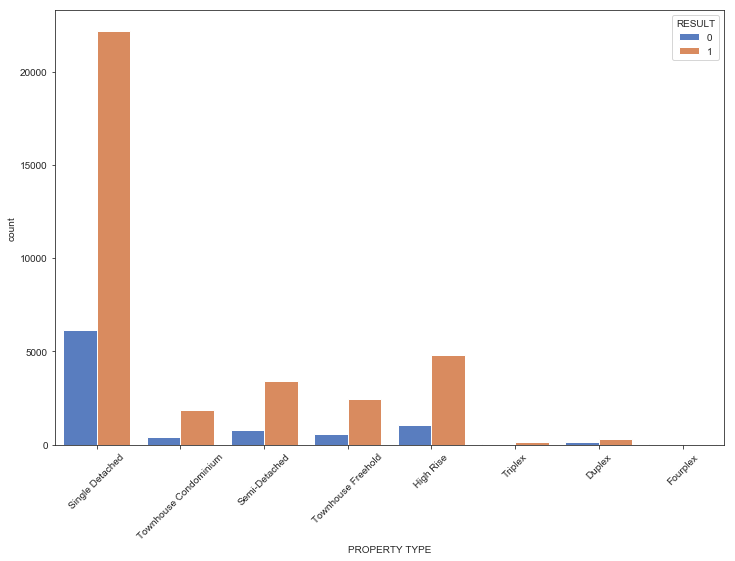

In [142]:
plt.figure(figsize=(12,8))
sns.countplot(df['PROPERTY TYPE'], hue=df['RESULT'])
plt.xticks(rotation=45);

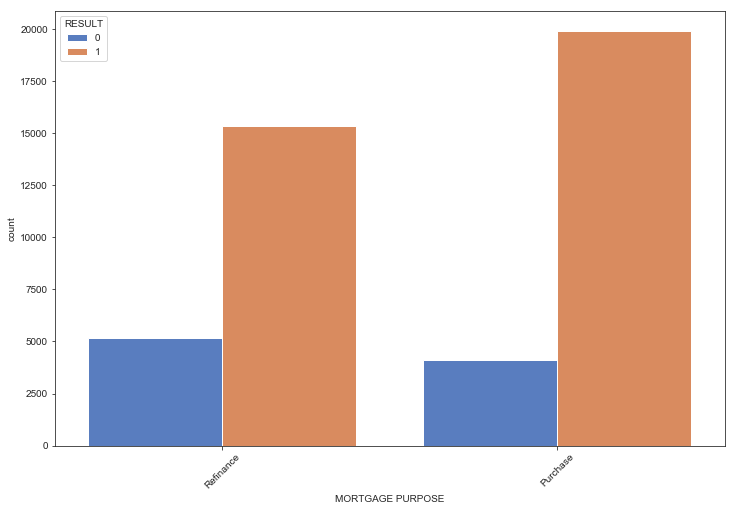

In [143]:
plt.figure(figsize=(12,8))
sns.countplot(df['MORTGAGE PURPOSE'], hue=df['RESULT'])
plt.xticks(rotation=45);

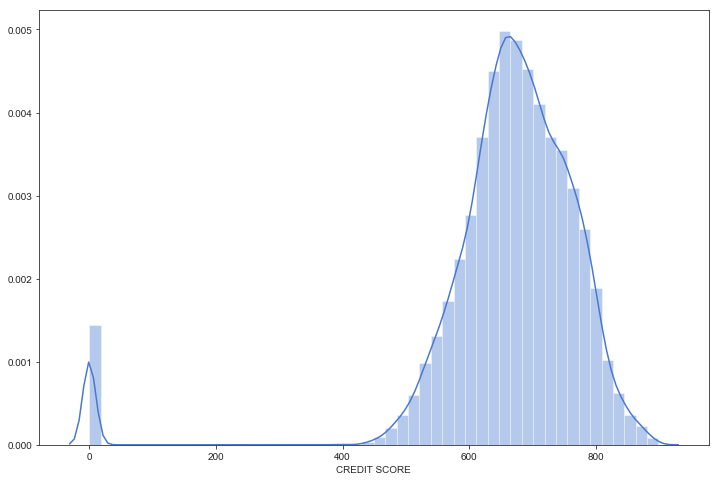

In [144]:
plt.figure(figsize=(12,8))
sns.distplot(df['CREDIT SCORE']);

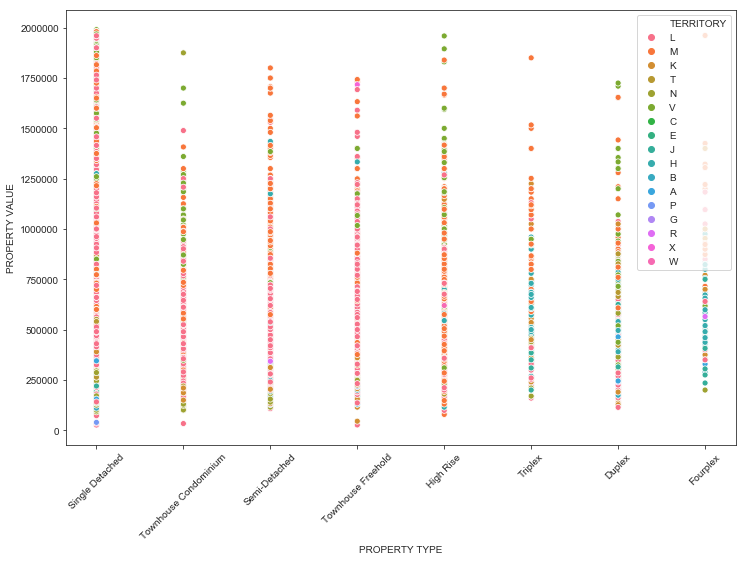

In [145]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="PROPERTY TYPE", y="PROPERTY VALUE", 
                hue = 'TERRITORY',
                data=df)
plt.xticks(rotation=45);

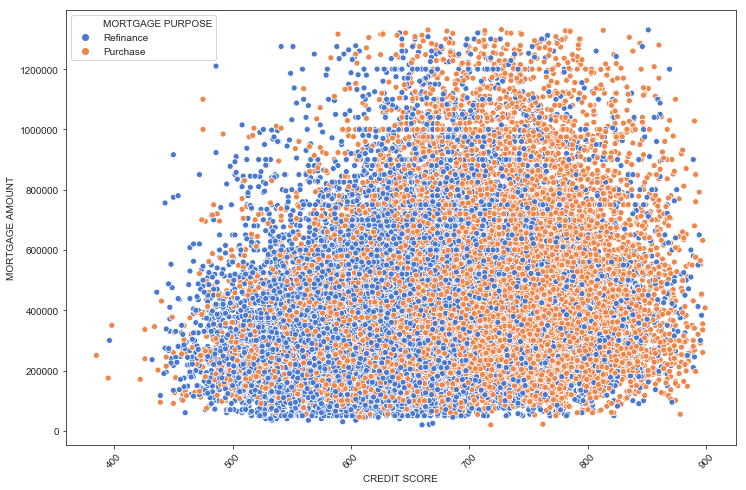

In [146]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='CREDIT SCORE', y="MORTGAGE AMOUNT", 
                hue = 'MORTGAGE PURPOSE',
                data=df[df['CREDIT SCORE'] > 0])
plt.xticks(rotation=45);

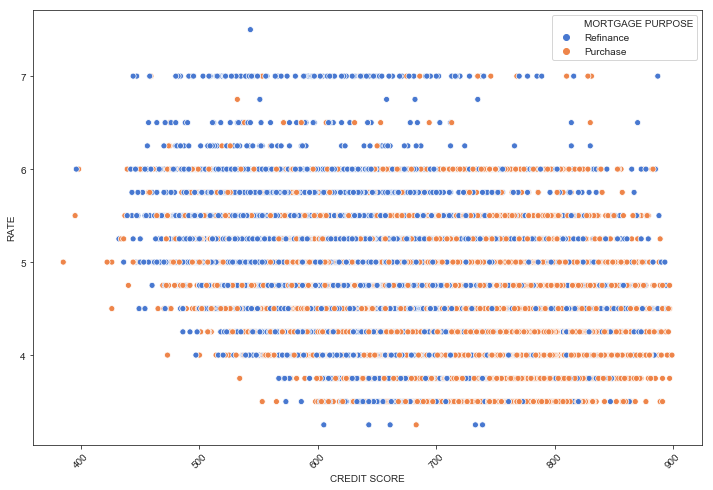

In [147]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='CREDIT SCORE', y="RATE", 
                hue = 'MORTGAGE PURPOSE',
                data=df[df['CREDIT SCORE'] > 0])
plt.xticks(rotation=45);

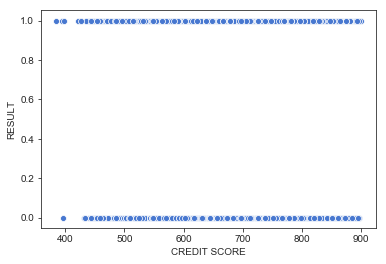

In [148]:
plt.figure(figsize=(6,4))
data = df
x1 = df[df['CREDIT SCORE'] > 0]['CREDIT SCORE']
y1 = df[df['CREDIT SCORE'] > 0]['RESULT']

ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

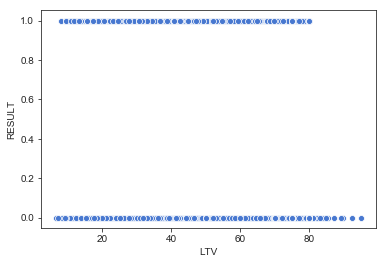

In [149]:
plt.figure(figsize=(6,4))
data = df
x1 = df[df['LTV'] > 0]['LTV']
y1 = df[df['LTV'] > 0]['RESULT']

ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

In [150]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'TERRITORY',
       'URBAN', 'RESULT'],
      dtype='object')

## ENCODING & FEATURE ENGINEERING

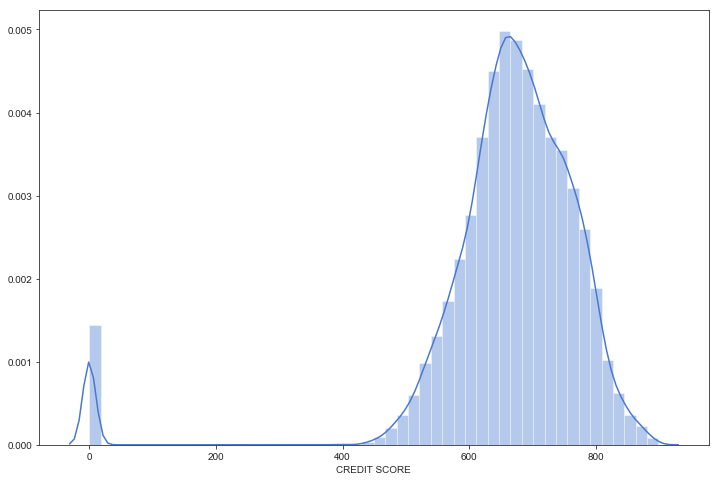

In [151]:
plt.figure(figsize=(12,8))
sns.distplot(df['CREDIT SCORE']);

In [152]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'TERRITORY',
       'URBAN', 'RESULT'],
      dtype='object')

In [153]:
#features_to_encode = ['AGE RANGE', 'AMORTIZATION', 'MORTGAGE PURPOSE', 'PAYMENT FREQUENCY', 'GENDER']
#features_to_dummy = ['NAICS CODE', 'PROPERTY TYPE', 'TERRITORY']

columns_to_drop = []
drop_first = False

def encode(df):
    
    # Encode Age Range
    le_age_range = LabelEncoder()
    df['AGE RANGE'] = le_age_range.fit_transform(df['AGE RANGE'])
    df['AGE RANGE'] = df['AGE RANGE'].apply(lambda x: x + 1)
    df['AGE RANGE'] = df['AGE RANGE'].replace({11:0})
    
    #Encode Mortgage Purpose
    le_purpose = LabelEncoder()
    df['MORTGAGE PURPOSE'] = le_purpose.fit_transform(df['MORTGAGE PURPOSE'])
    
    #Encode Payment Frequency
    le_frequency = LabelEncoder()
    df['PAYMENT FREQUENCY'] = le_frequency.fit_transform(df['PAYMENT FREQUENCY'])
    #df.drop(['PAYMENT FREQUENCY'], axis=1, inplace=True)
    
    #Encode Gender
    le_gender = LabelEncoder()
    df['GENDER'] = le_gender.fit_transform(df['GENDER'])
    
    #Encode Term
    le_gender = LabelEncoder()
    df['TERM'] = le_gender.fit_transform(df['TERM'])
    
    #Territory Dummy Variables
    df_temp = pd.get_dummies(df['TERRITORY'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['TERRITORY'], axis=1, inplace=True)
    
    #NAICS Dummy Variables
    df_temp = pd.get_dummies(df['NAICS CODE'], prefix='NAICS', drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['NAICS CODE'], axis=1, inplace=True)
    
    #Property Type Dummy Variables
    df_temp = pd.get_dummies(df['PROPERTY TYPE'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['PROPERTY TYPE'], axis=1, inplace=True)
    
    #Income Type Dummy Variables
    df_temp = pd.get_dummies(df['INCOME TYPE'], prefix='INCOME_TYPE', drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['INCOME TYPE'], axis=1, inplace=True)
    
    #Encode Amortization
    le_amortization = LabelEncoder()
    df['AMORTIZATION'] = le_amortization.fit_transform(df['AMORTIZATION'])
    
    #Payment Frequency Dummy Variables
    #df_temp = pd.get_dummies(df['PAYMENT FREQUENCY'], prefix='PMT_FREQ', drop_first=False)
    #df = pd.concat([df, df_temp], axis=1)
    #df.drop(['PAYMENT FREQUENCY'], axis=1, inplace=True)
    
    #Drop Columns
    df.drop(columns_to_drop, axis=1, inplace=True)
    
    return df

df = encode(df)

In [154]:
df.head()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,...,INCOME_TYPE_11,INCOME_TYPE_12,INCOME_TYPE_13,INCOME_TYPE_14,INCOME_TYPE_15,INCOME_TYPE_16,INCOME_TYPE_17,INCOME_TYPE_18,INCOME_TYPE_19,INCOME_TYPE_20
Unique_ID,,,,,,,,,,,,,,,,,,,,,
CAX_Train_1,1.600000e+06,5429,61.98,65.00,71.63,5,1040000.0,4.0,1,2,...,0,0,0,0,0,0,0,0,0,0
CAX_Train_2,5.249697e+05,2179,35.22,74.29,40.65,5,390000.0,4.5,1,2,...,0,0,0,0,0,0,0,0,0,0
CAX_Train_3,5.310000e+05,2152,30.97,80.00,35.41,5,424800.0,3.5,0,2,...,0,0,0,0,0,0,0,0,0,0
CAX_Train_4,1.280000e+06,5410,19.04,75.00,34.14,5,960000.0,5.5,0,2,...,0,0,0,0,0,0,0,0,0,0
CAX_Train_5,7.400000e+05,3342,29.59,80.00,34.85,5,592000.0,5.0,1,2,...,0,0,0,0,0,0,0,0,0,0


In [155]:
 def add_features(df):

    # Binary Variable if Credit Score = Zero
    df['ZERO SCORE'] = np.where(df['CREDIT SCORE'] == 0, 1, 0)
    
    # Interactions with 'Rate'
    df['RATE_X_CREDIT_SCORE'] = df['RATE'] * df['CREDIT SCORE']
    df['RATE_X_LTV'] = df['RATE'] * df['LTV']
    df['RATE_X_GENDER'] = df['RATE'] * df['GENDER']
    df['RATE_X_URBAN'] = df['RATE'] * df['URBAN']
    df['RATE_X_PROPERTY_VAL'] = df['RATE'] * df['PROPERTY VALUE']
    
    # Interaction between Urban / Rural & Property Value
    df['URBAN_X_PROPERTY_VAL'] = df['URBAN'] * df['PROPERTY VALUE']
    
    # LTV & Credit Score Interactions
    df['LTV_X_CREDIT'] = df['LTV'] * df['CREDIT SCORE']
    df['LTV_X_PURPOSE'] = df['LTV'] * df['MORTGAGE PURPOSE']
    df['RATE_X_PROPERTY_VAL'] = df['RATE'] * df['PROPERTY VALUE']
    df['CREDIT_X_INCOME'] = df['CREDIT SCORE'] * df['INCOME']
    df['PURPOSE_X_CREDIT'] = df['MORTGAGE PURPOSE'] * df['CREDIT SCORE']
    df['GDS_X_CREDIT'] = df['GDS'] * df['CREDIT SCORE']
    
    # Morgage Purpose & Property Value Interaction
    df['PURPOSE_X_PROPERTY_VAL'] = df['MORTGAGE PURPOSE'] * df['PROPERTY VALUE']
    
    df['CREDIT_SCORE^2'] = df['CREDIT SCORE'] ** 2
    df['INCOME_2'] = df['INCOME'] ** 2
    df['LTV_2'] = df['LTV'] ** 2
    df['GDS^2'] = df['GDS'] ** 2
    
    df['CREDIT_SCORE^3'] = df['CREDIT SCORE'] ** 3
    df['INCOME^3'] = df['INCOME'] ** 3
    df['LTV^3'] = df['LTV'] ** 3
    df['GDS^3'] = df['GDS'] ** 3
    
    #df = df.drop(['RATE'], axis=1)
    #df.drop(['PAYMENT FREQUENCY'], axis=1, inplace=True)
    
    return df

df = add_features(df)

In [156]:
len(df.columns)

103

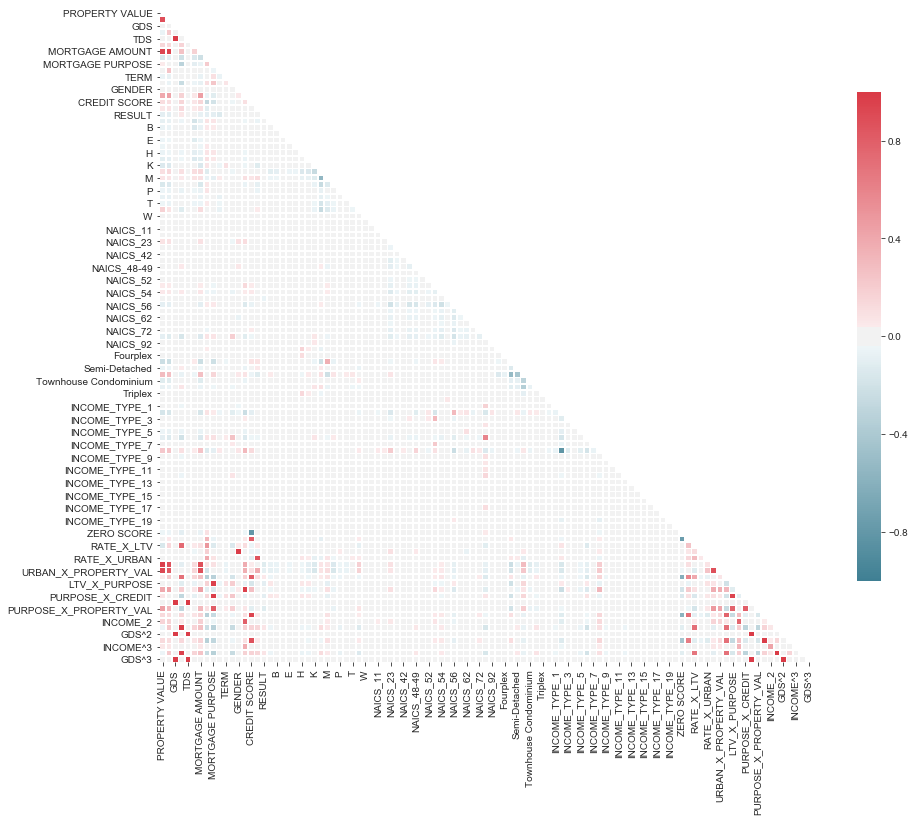

In [157]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

## BASELINE DUMMY CLASSIFIER

In [158]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import PolynomialFeatures

In [159]:
def dummy_classifier(df):
    
    y = df['RESULT']
    X = df.drop(['RESULT'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    dummy_classifier = DummyClassifier(strategy="most_frequent")
    dummy_classifier.fit( X,y )
    
    print('Dummy Accuracy score: ', accuracy_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy Precision score: ', precision_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy Recall score: ', recall_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy AUC score: ', roc_auc_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy F1 score: ', f1_score(y_test, dummy_classifier.predict(X_test)))
        
dummy_classifier(df)

Dummy Accuracy score:  0.7877807726864331
Dummy Precision score:  0.7877807726864331
Dummy Recall score:  1.0
Dummy AUC score:  0.5
Dummy F1 score:  0.8812946024726103


## BASELINE LOGISTIC REGRESSION

In [160]:
def prepare_data(df):
    
    #Separate Target & Feature
    y = df['RESULT']
    features = df.drop(['RESULT'], axis=1)
    
    #Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=17, test_size = 0.20)
    
    #Scale Data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(data = scaler.transform(X_train), columns=features.columns)
    X_test = pd.DataFrame(data = scaler.transform(X_test), columns=features.columns)
    
    return X_train, X_test, y_train, y_test, y, features

X_train, X_test, y_train, y_test, y, features = prepare_data(df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


## No Adjustment for Imbalance

In [161]:
def baseline_logreg(X_train, X_test, y_train, y_test):

    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, y_train)
    reg_predict = logreg.predict(X_test)

    print('Train Accuracy score: ', accuracy_score(y_train, logreg.predict(X_train)))
    print('Test Accuracy score: ', accuracy_score(y_test, reg_predict),'\n')
    print('Train F1 score: ', f1_score(y_train, logreg.predict(X_train)))
    print('Test F1 score: ', f1_score(y_test, reg_predict), '\n')
    print("Testing Precision Score: ", precision_score(y_test, reg_predict))
    print("Testing Recall Score: ", recall_score(y_test, reg_predict))
    print('TestAUC score: ', roc_auc_score(y_test, reg_predict))
    
    return reg_predict, logreg

reg_predict, logreg = baseline_logreg(X_train, X_test, y_train, y_test)

Train Accuracy score:  0.7944628516875386
Test Accuracy score:  0.786837376460018 

Train F1 score:  0.8840340927093565
Test F1 score:  0.8792159857451953 

Testing Precision Score:  0.7939317319848294
Testing Recall Score:  0.9850278055040639
TestAUC score:  0.5184261185108897


In [162]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (reg_predict == 1).sum())
print('Modeled Not Funded: ', (reg_predict == 0).sum())

Target Funded:  7013
Target Not Funded:  1891
Modeled Funded:  8701
Modeled Not Funded:  203


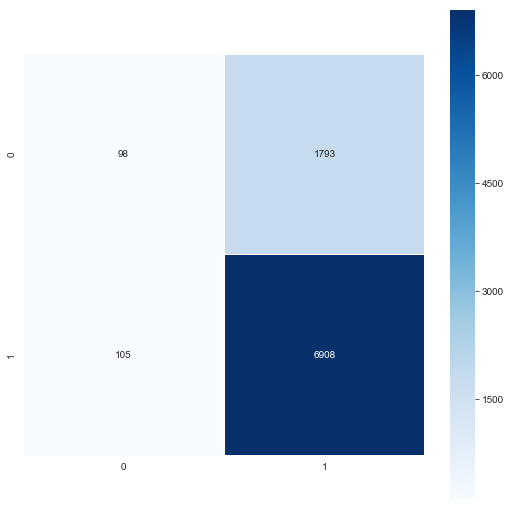

In [163]:
#Baseline Confusion Matrix
cm_lr = confusion_matrix(y_test, reg_predict)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = 'g', linewidths = .5, square = True, cmap = "Blues");

AUC:  0.7059400073128524


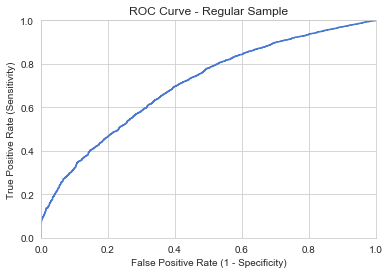

In [164]:
#Baseline ROC Curve
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve - Regular Sample')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, y_pred_prob));

In [165]:
model_params = list(zip(df.columns, logreg.coef_[0]))

model_params.sort(key = lambda x: abs(x[1]), reverse=True)
model_params;

## SMOTE Over Sample

In [166]:
def smote_logreg(X_train, X_test, y_train, y_test):
    
    sm = SMOTE(random_state=23, ratio=1.0)
    X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
    
    smote_lr = LogisticRegression(solver='liblinear')
    smote_lr.fit(X_train_smote, y_train_smote)
    smote_pred = smote_lr.predict(X_test)
    
    print('Train Accuracy score: ', accuracy_score(y_train_smote, smote_lr.predict(X_train_smote)))
    print('Test Accuracy score: ', accuracy_score(y_test, smote_pred),'\n')
    print("Testing Precision Score: ", precision_score(y_test, smote_pred))
    print("Testing Recall Score: ", recall_score(y_test, smote_pred))
    print('Test F1 score: ', f1_score(y_test, smote_pred))
    
    return smote_pred, smote_lr, X_train_smote, y_train_smote

smote_pred, smote_lr, X_train_smote, y_train_smote = smote_logreg(X_train, X_test, y_train, y_test)

Train Accuracy score:  0.6414706715783508
Test Accuracy score:  0.6317385444743935 

Testing Precision Score:  0.8736989591673339
Testing Recall Score:  0.6224155140453443
Test F1 score:  0.7269547839120658


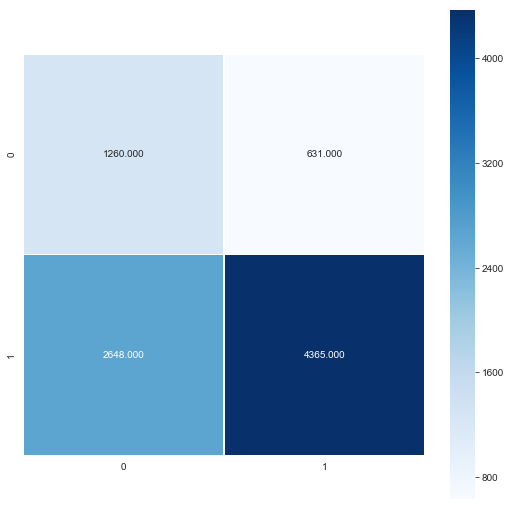

In [167]:
#SMOTE Confusion Matrix
cm_lr = confusion_matrix(y_test, smote_pred)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

AUC:  0.7023030357688068


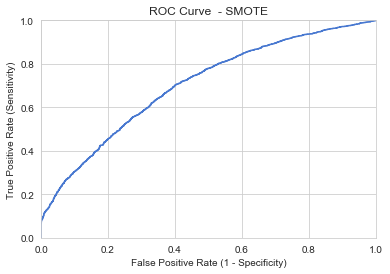

In [168]:
#SMOTE ROC Curve
smote_pred_prob = smote_lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, smote_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve  - SMOTE')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, smote_pred_prob));

## Random Under Sample

In [169]:
def under_sample(X_train, X_test, y_train, y_test):
    
    rus = RandomUnderSampler(random_state=0)
    X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
    
    rus_lr = LogisticRegression(solver='liblinear')
    rus_lr.fit(X_train_rus, y_train_rus)
    rus_pred = rus_lr.predict(X_test)

    print('Train Accuracy score: ', accuracy_score(y_train, rus_lr.predict(X_train)))
    print('Test Accuracy score: ', accuracy_score(y_test, rus_pred),'\n')
    print('Train F1 score: ', f1_score(y_train, rus_lr.predict(X_train)))
    print('Test F1 score: ', f1_score(y_test, rus_pred))
    
    return rus_pred, rus_lr, X_train_rus, y_train_rus

rus_pred, rus_lr, X_train_rus, y_train_rus = under_sample(X_train, X_test, y_train, y_test)

Train Accuracy score:  0.6334868310215084
Test Accuracy score:  0.6312893081761006 

Train F1 score:  0.7321637426900585
Test F1 score:  0.7266672217134293


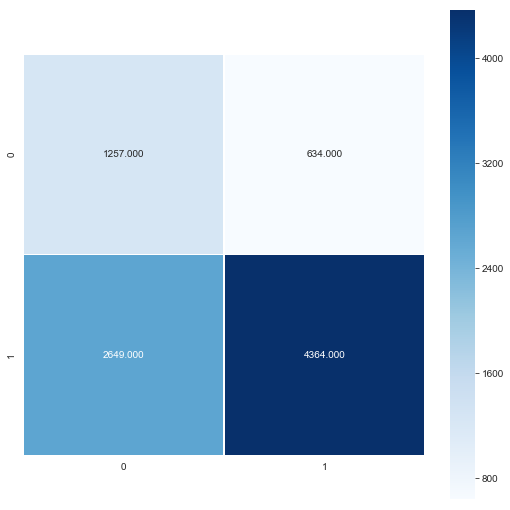

In [170]:
#Random Under Sampling Confusion Matrix
cm_lr = confusion_matrix(y_test, rus_pred)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

AUC:  0.7025548910714505


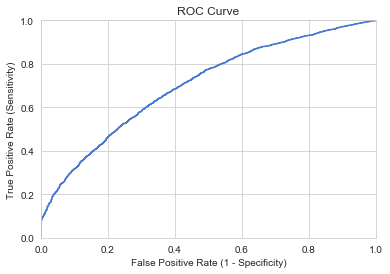

In [171]:
#Random Under Sampling ROC Curve
rus_pred_prob = rus_lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, rus_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, rus_pred_prob));

## Decision Tree

In [172]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train, X_test, y_train, y_test):
    
    dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=21, min_samples_leaf=10, min_impurity_decrease=0.0005)
    dt_clf = dt_clf.fit(X_train, y_train)
    
    y_pred_train = dt_clf.predict(X_train)
    decision_tree_pred = dt_clf.predict(X_test)
    
    print("Testing Accuracy Score:", accuracy_score(y_test, decision_tree_pred))
    print("Testing F1 Score:", f1_score(y_test, decision_tree_pred))
    print("Testing Precision Score: ", precision_score(y_test, decision_tree_pred))
    print("Testing Recall Score: ", recall_score(y_test, decision_tree_pred))
    print('AUC: ', roc_auc_score(y_test, decision_tree_pred))
    
    return decision_tree_pred, dt_clf

decision_tree_pred, dt_clf = decision_tree(X_train_smote, X_test, y_train_smote, y_test)

Testing Accuracy Score: 0.762915543575921
Testing F1 Score: 0.8617822300792247
Testing Precision Score:  0.7967312348668281
Testing Recall Score:  0.9384001140738628
AUC:  0.5252550543928277


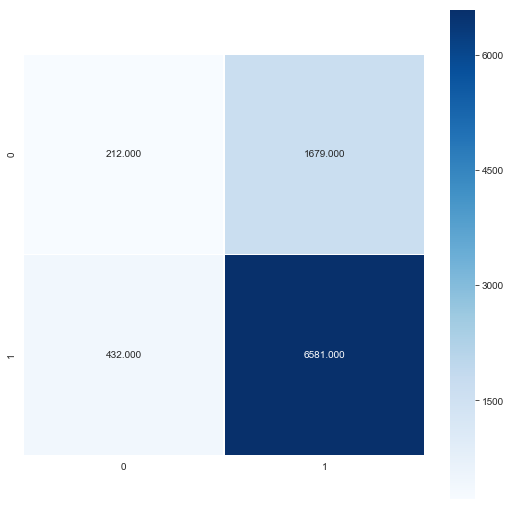

In [173]:
cm_lr = confusion_matrix(y_test, decision_tree_pred)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

AUC:  0.621999877390203


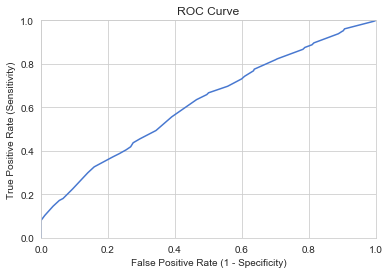

In [174]:
decision_tree_prob = dt_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, decision_tree_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, decision_tree_prob));

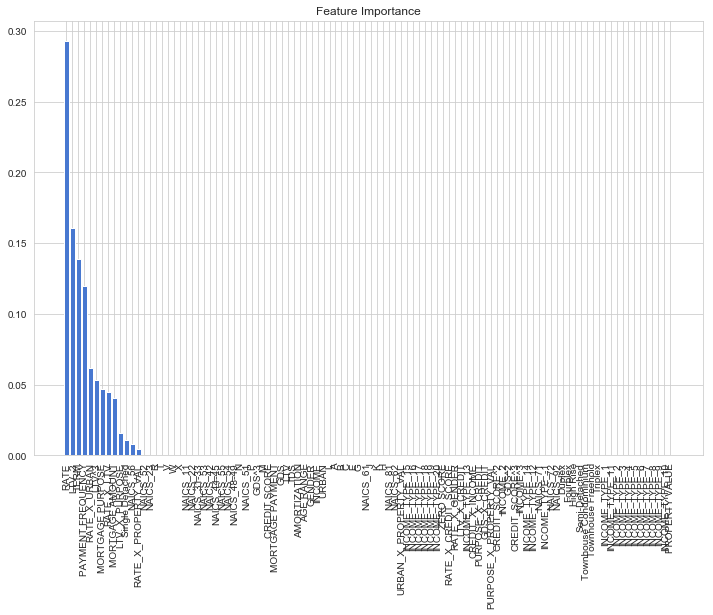

In [175]:
sns.set_style('whitegrid')
importances = dt_clf.feature_importances_

indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(12,8))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(features.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(features.shape[1]), names, rotation=90)

# Show plot
plt.show();

In [176]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (decision_tree_pred == 1).sum())
print('Modeled Not Funded: ', (decision_tree_pred == 0).sum())

Target Funded:  7013
Target Not Funded:  1891
Modeled Funded:  8260
Modeled Not Funded:  644


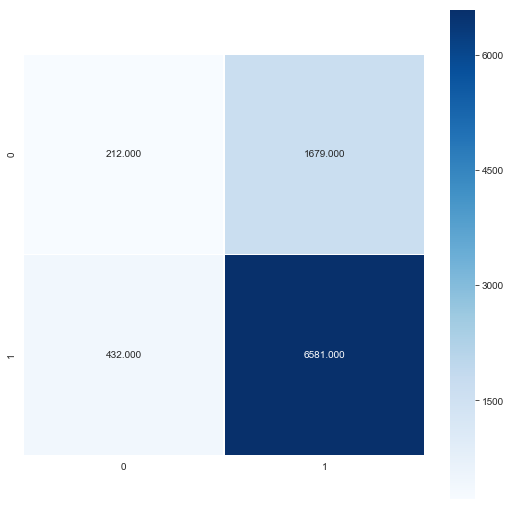

In [177]:
cm_lr = confusion_matrix(y_test, decision_tree_pred)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

AUC:  0.621999877390203


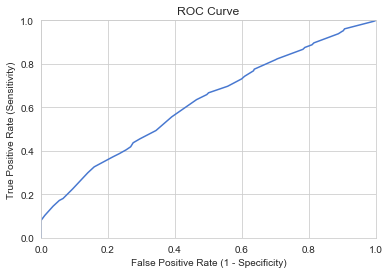

In [178]:
decision_tree_prob = dt_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, decision_tree_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, decision_tree_prob));

In [115]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [116]:
# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter space
# C = C_param_range = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10,]

# # Create hyperparameter options
# hyperparameters_1 = dict(C=C, penalty=penalty)

In [117]:
# # Create grid search using 5-fold cross validation
# clf_gs = GridSearchCV(dt_clf, hyperparameters, cv=5, scoring='f1')

In [118]:
# model = clf_gs.fit(X_train, y_train)

## Randomized Search - Decision Tree

In [360]:
def run_randomized_search(X_train, y_train):

    clf = DecisionTreeClassifier()

    param_distributions = {
                  'criterion': ['entropy', 'gini'],
                  'max_depth': range(5,50, 2), 
                  'min_samples_leaf': range(1,25,1),
                  'min_impurity_decrease': [0.0005, 0.001]
                 }

    randomized_search = RandomizedSearchCV(estimator=clf,cv=5, param_distributions=param_distributions, scoring='f1')
    randomized_search = randomized_search.fit(X_train, y_train)

    best_clf = randomized_search.best_estimator_

    print('Randomized Search Best Score: ', randomized_search.best_score_)
    print('Ranodmized Search Best Params: ', randomized_search.best_params_)
    print('Randomized Search Best Estimator: ', randomized_search.best_estimator_)
    print('Randomized Search Best F1 Score: ', f1_score(y_test, best_clf.predict(X_test)))

run_randomized_search(X_train_smote, y_train_smote)

0.7827271410927243
{'min_samples_split': 4, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0005, 'max_depth': 20, 'criterion': 'entropy'}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


## Random Forest Classifier

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [181]:
def run_RFC(X_train, y_train):
    
    rfc = RandomForestClassifier(criterion='entropy', max_features=0.625, n_estimators=200, random_state=17)

    rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)

    # Print Scores
    print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))
    print('Test Precision score: ', precision_score(y_test, rfc_pred))
    print('Test Recall score: ', recall_score(y_test, rfc_pred))
    print('Test F1 score: ', f1_score(y_test, rfc_pred))
    
    return rfc, rfc_pred
    
rfc, rfc_pred = run_RFC(X_train_smote, y_train_smote)

Test Accuracy score:  0.7702156334231806
Test Precision score:  0.8048361360009819
Test Recall score:  0.9349778981890774
Test F1 score:  0.8650395778364117


In [121]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (rfc_pred == 1).sum())
print('Modeled Not Funded: ', (rfc_pred == 0).sum())

Target Funded:  7013
Target Not Funded:  1891


NameError: name 'rfc_pred' is not defined

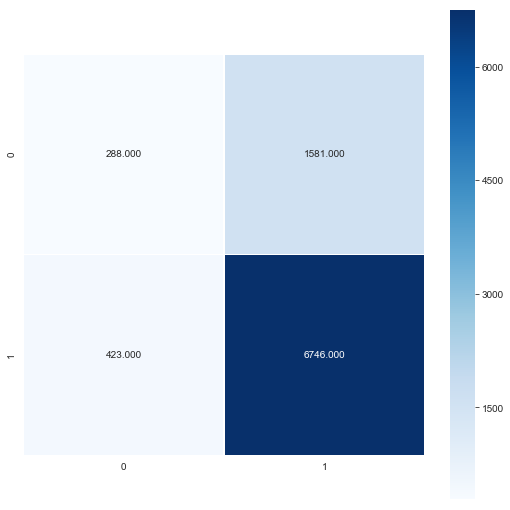

In [181]:
cm_lr = confusion_matrix(y_test, rfc_pred)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

## Randomized Search - Random Forest

In [179]:
clf = RandomForestClassifier(criterion='entropy')

param_distributions = {
              'n_estimators': [150, 200, 250, 300],
              'max_features': [0.25, 0.375, 0.50, 0.625, 0.75]
             }

randomized_search = RandomizedSearchCV(estimator=clf,cv=5, param_distributions=param_distributions,scoring='f1')
randomized_search = randomized_search.fit(X_train_smote, y_train_smote)

best_clf = randomized_search.best_estimator_

print(randomized_search.best_score_)
print(randomized_search.best_params_)
print(randomized_search.best_estimator_)

0.872968212053961
{'n_estimators': 200, 'max_features': 0.625}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.625, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [180]:
f1_score(y_test, randomized_search.predict(X_test))

0.8646651270207854

In [ ]:
from numpy import loadtxt
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]= "True"

In [ ]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 15, alpha = 15, n_estimators = 250)

In [ ]:
xg_clf.fit(X_train, y_train)

In [ ]:
xg_preds = xg_clf.predict(X_test)

In [ ]:
print('Test Accuracy score: ', accuracy_score(y_test, xg_preds))
print('Test Precision score: ', precision_score(y_test, xg_preds))
print('Test Recall score: ', recall_score(y_test, xg_preds))
print('Test F1 score: ', f1_score(y_test, xg_preds))

In [ ]:
cm_lr = confusion_matrix(y_test, xg_preds)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

In [ ]:
cm_lr = confusion_matrix(y_test, xg_preds)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

## Run Entire Training Set for Competition

In [368]:
def prep_total_train(df):
    
    #Separate Target & Feature
    y = df['RESULT']
    features = df.drop(['RESULT'], axis=1)
    
    #Scale Data
    scaler = StandardScaler()
    scaler.fit(features)
    X_train_all = pd.DataFrame(data = scaler.transform(features), columns=features.columns)
    
    return X_train_all, y

X_train_all, y_all = prep_total_train(df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [369]:
# Decision Tree
dt_clf.fit(X_train_all, y_all)
    
#Random Forest
rfc.fit(X_train_all, y_all)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=21,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=65, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [370]:
file = pd.read_csv('CAX_MortgageModeling_Test.csv')
submission = pd.read_csv('CAX_MortgageModeling_SubmissionFormat.csv')

test_df = pd.DataFrame(file)
submission_df = pd.DataFrame(submission)

test_df = test_df.drop(['RESULT'], axis=1)

In [371]:
#Clean, Encode, Add Features
test_df = add_features(encode(clean_data(test_df)))

In [372]:

X_train, test_df = X_train.align(test_df, axis=1)
test_df = test_df.fillna(0)

In [373]:
x = dt_clf.predict(test_df)
y = rfc.predict(test_df)

In [374]:
x.sum()
y.sum()

15214

6